In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Explore a base model that only uses microdensities to determine the next microdensity.
Thus, to increase our data:  
- We have 39 instances per county
- We can use the first 20 to calculate the 21, then 2-21 to calculate 22, and so on.
- We then have trained a model that can predict the next microdensity based on previous instances.

- As a later stage we can include census information as an extra filtering technique

In [35]:
df = pd.read_csv(
    "../data/processed/county_data.csv",
    usecols=[
        "cfips",
        "first_day_of_month",
        "active",
        "POPESTIMATE2021",
        "microbusiness_density",
    ],
)
test = pd.read_csv("../data/raw/test.csv")

In [36]:
df.head()

,cfips,first_day_of_month,microbusiness_density,active,POPESTIMATE2021
0,1001,2019-08-01,3.007682,1249,59095
1,1001,2019-09-01,2.884870,1198,59095
2,1001,2019-10-01,3.055843,1269,59095
3,1001,2019-11-01,2.993233,1243,59095
4,1001,2019-12-01,2.993233,1243,59095


In [37]:
df["cfips"].value_counts()

1001     39
39133    39
39089    39
39091    39
39093    39
         ..
21113    39
21115    39
21117    39
21119    39
56045    39
Name: cfips, Length: 3135, dtype: int64

In [38]:
# Create an empty list to store the new time series
time_series = []

# Loop over each cfips
for cfips in df["cfips"].unique():
    # Filter the data for the current cfips
    df_cfips = df[df["cfips"] == cfips].reset_index(drop=True)
    # Loop over the time series from 0 to 14 (inclusive)
    for i in range(0, 15):
        # Create a new time series with the values for the current cfips and range of first_day_of_month
        time_series.append(
            {
                "cfips": cfips,
                "POPESTIMATE2021": df_cfips.loc[0, "POPESTIMATE2021"],
                "active": df_cfips.loc[0, "active"],
                "microbusiness_density": df_cfips.loc[
                    i : i + 23, "microbusiness_density"
                ].values.tolist(),
                "target": df_cfips.loc[i + 24, "microbusiness_density"],
                "target_date": df_cfips.loc[i + 24, "first_day_of_month"],
            }
        )

# Create a new dataframe with the list of time series
new_df = pd.DataFrame(time_series)

In [39]:
new_df.head()

,cfips,POPESTIMATE2021,active,microbusiness_density,target,target_date
0,1001,59095,1249,"[3.0076818, 2.8848701, 3.0558431, 2.9932332, 2...",3.219917,2021-08-01
1,1001,59095,1249,"[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...",3.186722,2021-09-01
2,1001,59095,1249,"[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...",3.203320,2021-10-01
3,1001,59095,1249,"[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...",3.200948,2021-11-01
4,1001,59095,1249,"[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...",3.286307,2021-12-01


In [40]:
# convert the list of microbusiness_density to a numpy array and then each into a column
new_df["microbusiness_density"] = new_df["microbusiness_density"].apply(
    lambda x: np.array(x)
)
new_df = pd.concat(
    [
        new_df.drop(["microbusiness_density"], axis=1),
        new_df["microbusiness_density"].apply(pd.Series),
    ],
    axis=1,
)
new_df.head()

,cfips,POPESTIMATE2021,active,target,target_date,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,1001,59095,1249,3.219917,2021-08-01,3.007682,2.884870,3.055843,2.993233,2.993233,...,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433
1,1001,59095,1249,3.186722,2021-09-01,2.884870,3.055843,2.993233,2.993233,2.969090,...,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917
2,1001,59095,1249,3.203320,2021-10-01,3.055843,2.993233,2.993233,2.969090,2.909326,...,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722
3,1001,59095,1249,3.200948,2021-11-01,2.993233,2.993233,2.969090,2.909326,2.933231,...,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320
4,1001,59095,1249,3.286307,2021-12-01,2.993233,2.969090,2.909326,2.933231,3.000167,...,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948


In [41]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47025 entries, 0 to 47024
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cfips            47025 non-null  int64  
 1   POPESTIMATE2021  47025 non-null  int64  
 2   active           47025 non-null  int64  
 3   target           47025 non-null  float64
 4   target_date      47025 non-null  object 
 5   0                47025 non-null  float64
 6   1                47025 non-null  float64
 7   2                47025 non-null  float64
 8   3                47025 non-null  float64
 9   4                47025 non-null  float64
 10  5                47025 non-null  float64
 11  6                47025 non-null  float64
 12  7                47025 non-null  float64
 13  8                47025 non-null  float64
 14  9                47025 non-null  float64
 15  10               47025 non-null  float64
 16  11               47025 non-null  float64
 17  12          

In [42]:
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test.sort_values(["cfips", "first_day_of_month"], inplace=True)

## Lets try first just with the timeseries

In [43]:
ids = df["cfips"].unique()
# create X, which is df_new without the target column
X = new_df.drop(["target", "target_date", "cfips", "POPESTIMATE2021", "active"], axis=1)
y = new_df["target"]
threshold = 0.1

In [44]:
# import group kfold
from sklearn.model_selection import GroupKFold

# import xgboost predictor
from xgboost import XGBRegressor

In [50]:
# create a group kfold object
group_kfold = GroupKFold(n_splits=5)
print(X.shape, y.shape, ids.shape)
# split the data and targets
for split, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups=ids)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Split {split}:")
    # predict with xgboost
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    # calculate the mean absolute error
    mae = np.mean(np.abs(y_pred - y_test))
    print(f"MAE: {mae}")
    # calculate the percentage of predictions that are within the threshold
    pct_within_threshold = np.mean(np.abs(y_pred - y_test) <= threshold)
    print(f"Percentage within threshold: {pct_within_threshold}")

(47025, 24) (47025,) (3135,)


ValueError: Found input variables with inconsistent numbers of samples: [47025, 47025, 3135]

In [ ]:
labelencoder = LabelEncoder()
df["pop_group_2020_numeric"] = labelencoder.fit_transform(df["pop_group_2020"])

In [ ]:
df.columns

Index(['cfips', 'year', 'CTYNAME', 'POPESTIMATE2020', 'POPESTIMATE2021',
       'STNAME', 'active', 'county', 'first_day_of_month', 'median_hh_inc',
       'microbusiness_density', 'pct_bb', 'pct_college', 'pct_foreign_born',
       'pct_it_workers', 'pop_group_2020', 'quarter', 'row_id', 'state',
       'pop_group_2020_numeric'],
      dtype='object')

<AxesSubplot: >

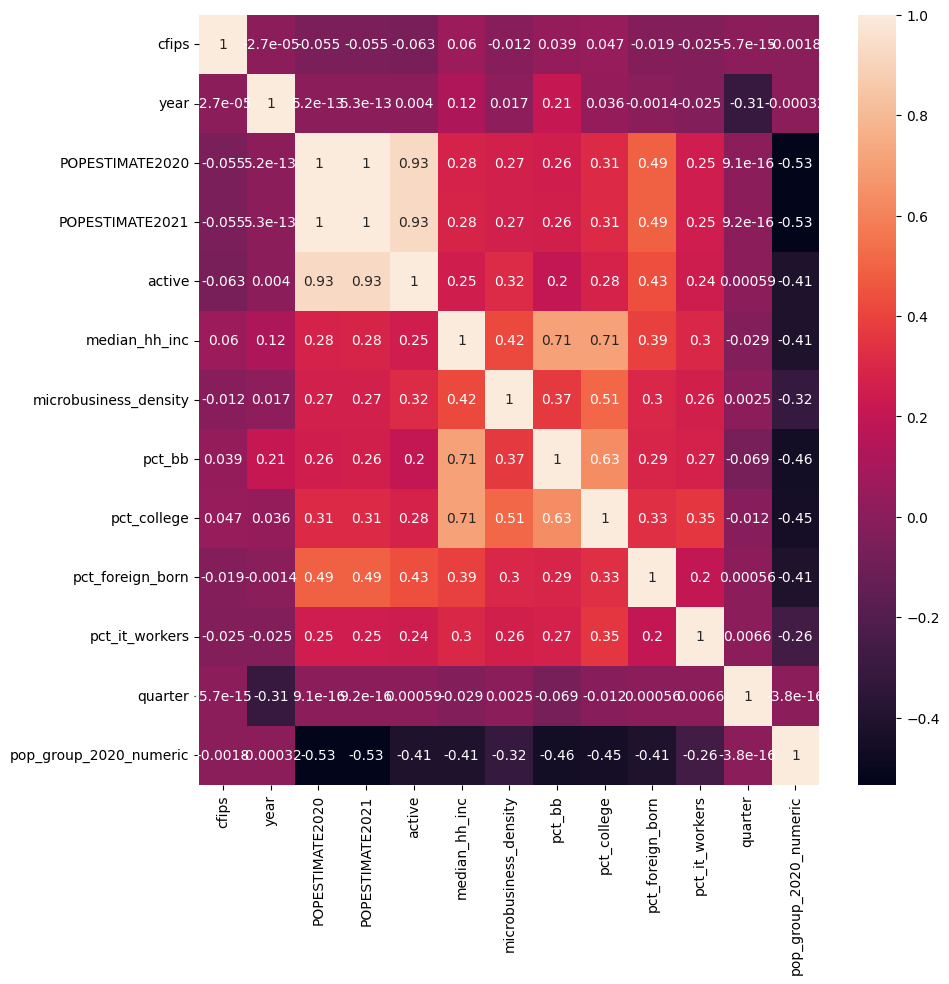

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

## Predictions of microdensity based on the data for that month, train on all the population

In [ ]:
useful_cols = [
    "cfips",
    "POPESTIMATE2021",
    "pop_group_2020_numeric",
    "median_hh_inc",
    "pct_bb",
    "pct_college",
    "pct_foreign_born",
    "pct_it_workers",
    "year",
]
X = df[useful_cols]

X.fillna(method="ffill", inplace=True)
X = X.apply(pd.to_numeric, errors="coerce")
# convert all columns to numeric


y = df["microbusiness_density"]
y.fillna(method="bfill", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X

,cfips,POPESTIMATE2021,pop_group_2020_numeric,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,year
0,1001,59095.00,1,58731.00,80.60,16.10,2.30,0.70,2019
1,1001,59095.00,1,58731.00,80.60,16.10,2.30,0.70,2019
2,1001,59095.00,1,58731.00,80.60,16.10,2.30,0.70,2019
3,1001,59095.00,1,58731.00,80.60,16.10,2.30,0.70,2019
4,1001,59095.00,1,58731.00,80.60,16.10,2.30,0.70,2019
...,...,...,...,...,...,...,...,...,...
122281,56045,6745.00,2,65566.00,81.30,13.90,1.60,0.00,2022
122282,56045,6745.00,2,65566.00,81.30,13.90,1.60,0.00,2022
122283,56045,6745.00,2,65566.00,81.30,13.90,1.60,0.00,2022
122284,56045,6745.00,2,65566.00,81.30,13.90,1.60,0.00,2022


In [ ]:
# find nan in X and y
X_train.isna().sum()

cfips                     0
POPESTIMATE2021           0
pop_group_2020_numeric    0
median_hh_inc             0
pct_bb                    0
pct_college               0
pct_foreign_born          0
pct_it_workers            0
year                      0
dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97828 entries, 10373 to 121958
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cfips                   97828 non-null  int64  
 1   POPESTIMATE2021         97828 non-null  float64
 2   pop_group_2020_numeric  97828 non-null  int32  
 3   median_hh_inc           97828 non-null  float64
 4   pct_bb                  97828 non-null  float64
 5   pct_college             97828 non-null  float64
 6   pct_foreign_born        97828 non-null  float64
 7   pct_it_workers          97828 non-null  float64
 8   year                    97828 non-null  int64  
dtypes: float64(6), int32(1), int64(2)
memory usage: 7.1 MB


In [ ]:
from lazypredict.Supervised import LazyRegressor

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

In [ ]:
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 21%|██▏       | 9/42 [00:16<01:41,  3.08s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor model failed to execute
Unable to allocate 71.3 GiB for an array with shape (97828, 97828) and data type float64


 40%|████      | 17/42 [00:26<00:25,  1.00s/it]

KernelRidge model failed to execute
Unable to allocate 71.3 GiB for an array with shape (97828, 97828) and data type float64


 62%|██████▏   | 26/42 [01:18<02:50, 10.64s/it]